# Agent Memory - Can LLMs *Really* Think?

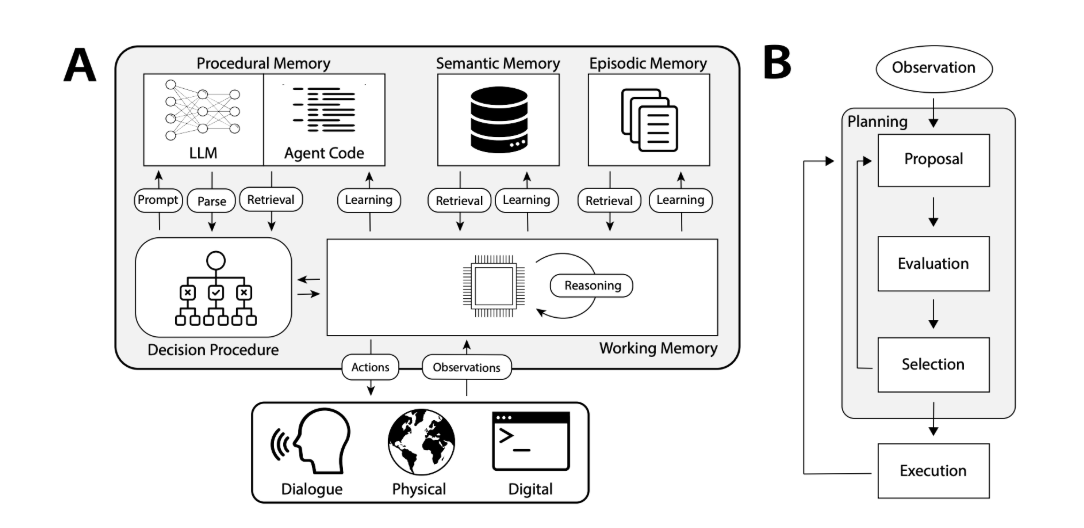

*[Cognitive Architectures for Language Agents, 2024](https://arxiv.org/pdf/2309.02427)*

LLMs are considered "stateless" in that every time you invoke an LLM call, it is like the first time it's ever seen the input being passed through. Given this quirk, multi-turn LLM agents have a unique challenge to overcome with fully understanding and navigating a vast world model which we humans do naturally.

Being a human has a lot of advantages over a language model when executing a task. We bring our general knowledge about the world and lived experience, our understanding of prior similar task experiences and their takeaways, what we've specifically learned how to do or been taught, and then our ability to instantly contextualize and shape our approach to a task as we're working through it. In essence, we have advanced memory and the ability to learn from and apply learnings to new experiences. 

LLMs sort of have some memory, mostly their general knowledge or traits picked up from training and additional fine tuning but suffer from a lack of the other characteristics outlined prior. To compensate for this, we can model different forms of memory, recall, and learning within our agentic system design. Specifically, we'll create a simple RAG agent to model 4 kinds of memory:

- **Working Memory** - Current conversation and immediate context
- **Episodic Memory** - Historical experiences and their takeaways
- **Semantic Memory** - Knowledge context and factual grounding
- **Procedural Memory** - The "rules" and "skills" for interaction

These four memory systems provide a holistic approach to understanding and architecting a part of cognitive design into an agent application. In this notebook we'll break down each type of memory and an example approach to implementing them into a whole agent experience.

---
## Working Memory

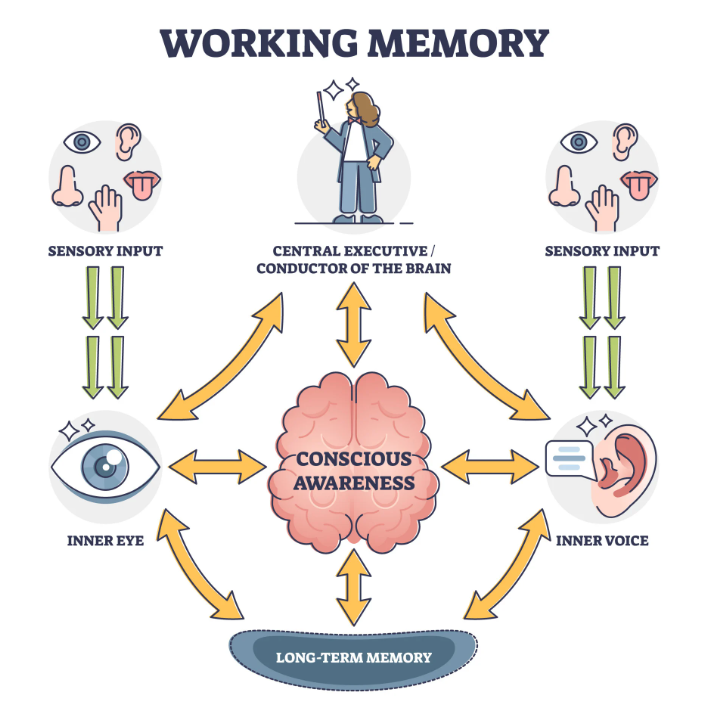

*[Working Memory Model (Baddeley and Hitch)](https://www.simplypsychology.org/working-memory.html)*

Working memory encompasses your active understanding and contextualization of immediate information requiring dynamic processing. For a chatbot, this represents the maintenance and manipulation of conversational context observed throughout real-time interactions.

The type of information maintained in working memory consists of active messages and roles, current task/goal parameters, immediate state representations, and contextual processing requirements. This includes message history with associated metadata, conversation state vectors, goal hierarchies, and temporary computational results requiring immediate access.

```python
chat_model.invoke([
    {
        "role": "system",
        "content": "You are a helpful AI Assistant.",
    },
    {
        "role": "user",
        "content": "Hello, how are you?",
    },
    {
        "role": "assistant",
        "content": "I'm doing well, thank you for asking.",
    },
    {
        "role": "user",
        "content": "Can you tell me a joke?",
    }
])
```

Remembering from working memory involves direct access to recent contextual data and action/result pairs. The system leverages immediate accessibility to maintain conversational coherence through continuous monitoring of the active message history, current state parameters, and ongoing computational processes. This direct access enables appropriate response generation grounded in the immediate conversational context.

Learning in working memory operates through continuous state updates during conversational processing. The system dynamically integrates new messages into the active context, updates state representations, modifies goal parameters, and maintains temporal coherence across the interaction. This real-time learning process differs fundamentally from the persistent storage mechanisms of episodic and semantic memory systems.

Working memory functions as the active computational interface, coordinating information flow between episodic experience retrieval and semantic knowledge access while maintaining precise state awareness of the current interaction.

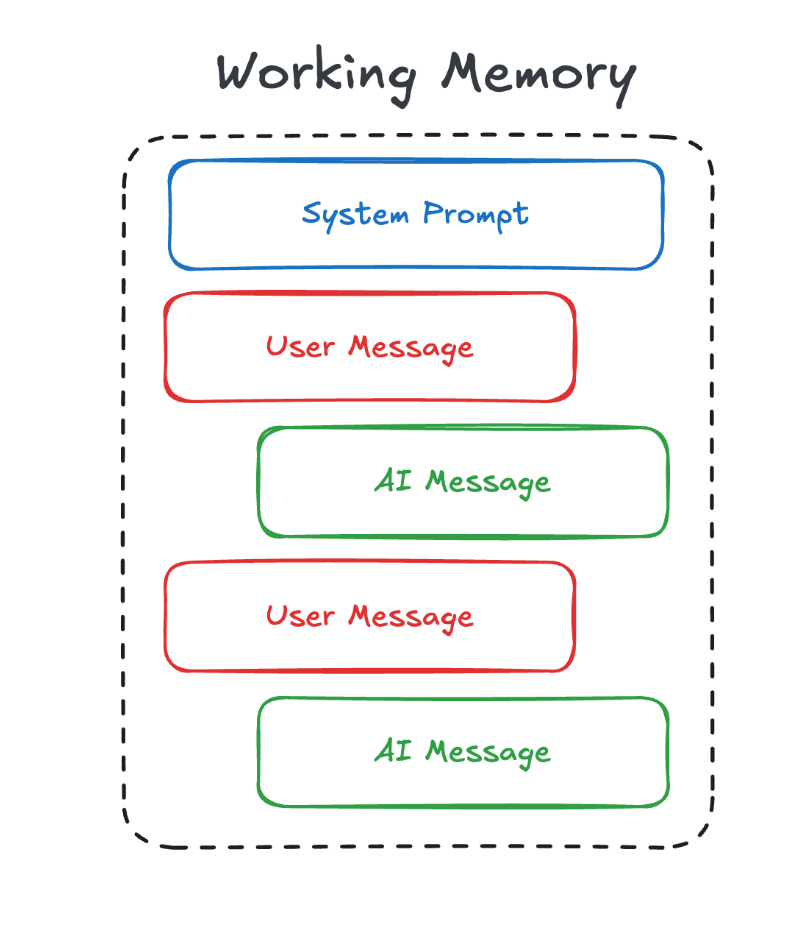

Looking at a simple example:

**Instantiate the Language Model**

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0.7, model="gpt-4o")

**Create Simple Back & Forth Chat Flow**

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

# Define System Prompt
system_prompt = SystemMessage("You are a helpful AI Assistant. Answer the User's queries succinctly in one sentence.")

# Start Storage for Historical Message History
messages = [system_prompt]

while True:

    # Get User's Message
    user_message = HumanMessage(input("\nUser: "))

    if user_message.content.lower() == "exit":
        break

    else:
        # Extend Messages List With User Message
        messages.append(user_message)

    # Pass Entire Message Sequence to LLM to Generate Response
    response = llm.invoke(messages)

    print("\nAI Message: ", response.content)

    # Add AI's Response to Message List
    messages.append(response)


User:  Hello!



AI Message:  Hello! How can I assist you today?



User:  What's my name



AI Message:  I'm sorry, but I don't have access to personal information, so I don't know your name.



User:  Oh my name is Adam!



AI Message:  Nice to meet you, Adam! How can I help you today?



User:  What's my name?



AI Message:  Your name is Adam.



User:  exit


Keeping track of our total conversation allows the LLM to use prior messages and interactions as context for immediate responses during an ongoing conversation, keeping our current interaction in working memory and recalling working memory through attaching it as context for subsequent response generations. 

In [ ]:
# Looking into our Memory
for i in range(len(messages)):
    print(f"\nMessage {i+1} - {messages[i].type.upper()}: ", messages[i].content)
    i += 1


Message 1 - SYSTEM:  You are a helpful AI Assistant. Answer the User's queries succinctly in one sentence.

Message 2 - HUMAN:  Hello!

Message 3 - AI:  Hello! How can I assist you today?

Message 4 - HUMAN:  What's my name

Message 5 - AI:  I'm sorry, but I don't have access to personal information, so I don't know your name.

Message 6 - HUMAN:  Oh my name is Adam!

Message 7 - AI:  Nice to meet you, Adam! How can I help you today?

Message 8 - HUMAN:  What's my name?

Message 9 - AI:  Your name is Adam.


---
## Episodic Memory

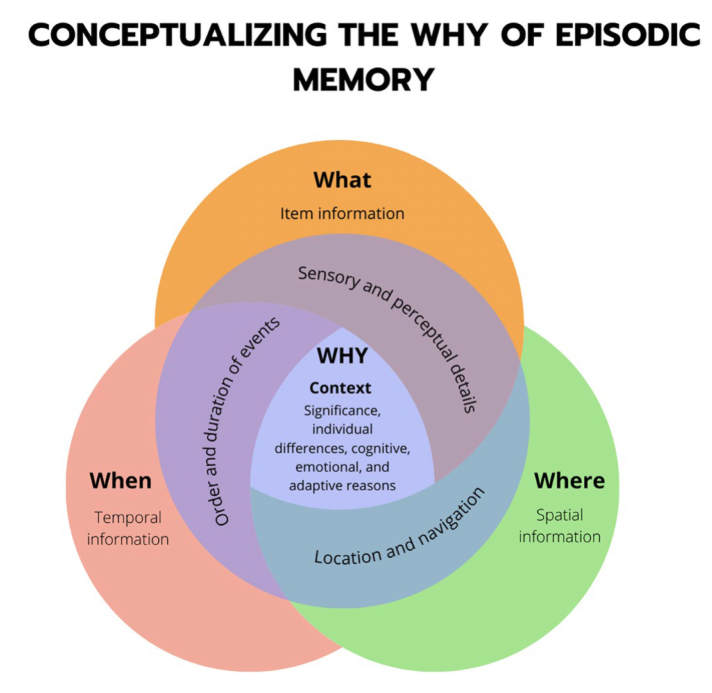

*[Tell me why: the missing w in episodic memory’s what, where, and when](https://link.springer.com/article/10.3758/s13415-024-01234-4)*

Episodic memory is a historical collection of prior experiences, or episodes. This can be both the literal recollection of how something happened and also any non-explicitly stated takeaways. When encountering a specific situation, you may recall similar related events that you've been in and their outcomes, which shape the way we approach new, comparable experiences.

For a chatbot, this includes both raw conversations it has participated in and the analytical understanding gained from those interactions. The act of remembering is implemented through dynamic [few-shot prompting](https://www.promptingguide.ai/techniques/fewshot), automatically providing similar successful examples and instructions to better guide an LLM's response on subsequent similar queries.

But we don't just recall similar experiences - we also extract takeaways (or learning) from interactions. Learning in episodic memory happens through two processes: automatic storage of complete conversations, and generation of post-conversation analysis. The system stores full interaction sequences while implementing reflection protocols to identify what worked, what didn't, and what can be learned for future situations. This dual approach enables both specific recall and strategic learning for future conversations.

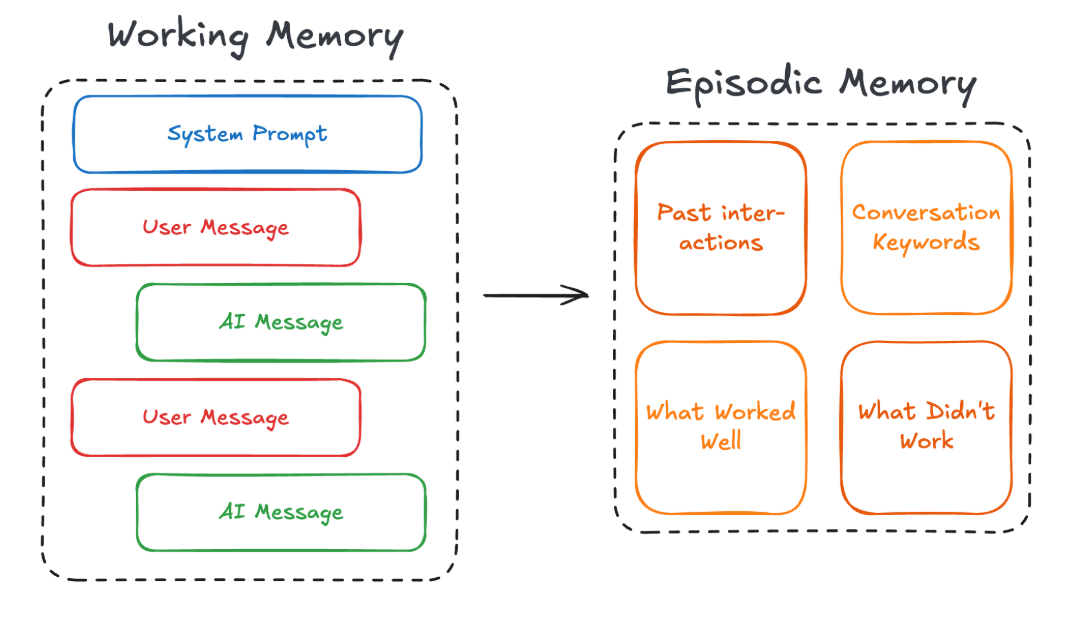

Episodic memory serves as the system's experiential foundation, allowing it to adapt its behavior based on accumulated conversation history while maintaining access to proven interaction patterns and their associated learnings. This creates a continuously improving system that learns not just from individual interactions, but from the patterns and insights derived across multiple conversations.

Let's implement this reflection, storage and retrieval:

**Creating a Reflection Chain**

This is where historical messages can be input, and episodic memories will be output. Given a message history, you will receive

```python
{
    "context_tags": [               # 2-4 keywords that would help identify similar future conversations
        string,                     # Use field-specific terms like "deep_learning", "methodology_question", "results_interpretation"
        ...
    ],
    "conversation_summary": string, # One sentence describing what the conversation accomplished
    "what_worked": string,          # Most effective approach or strategy used in this conversation
    "what_to_avoid": string         # Most important pitfall or ineffective approach to avoid
}
```

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

reflection_prompt_template = """
You are analyzing conversations about research papers to create memories that will help guide future interactions. Your task is to extract key elements that would be most helpful when encountering similar academic discussions in the future.

Review the conversation and create a memory reflection following these rules:

1. For any field where you don't have enough information or the field isn't relevant, use "N/A"
2. Be extremely concise - each string should be one clear, actionable sentence
3. Focus only on information that would be useful for handling similar future conversations
4. Context_tags should be specific enough to match similar situations but general enough to be reusable

Output valid JSON in exactly this format:
{{
    "context_tags": [              // 2-4 keywords that would help identify similar future conversations
        string,                    // Use field-specific terms like "deep_learning", "methodology_question", "results_interpretation"
        ...
    ],
    "conversation_summary": string, // One sentence describing what the conversation accomplished
    "what_worked": string,         // Most effective approach or strategy used in this conversation
    "what_to_avoid": string        // Most important pitfall or ineffective approach to avoid
}}

Examples:
- Good context_tags: ["transformer_architecture", "attention_mechanism", "methodology_comparison"]
- Bad context_tags: ["machine_learning", "paper_discussion", "questions"]

- Good conversation_summary: "Explained how the attention mechanism in the BERT paper differs from traditional transformer architectures"
- Bad conversation_summary: "Discussed a machine learning paper"

- Good what_worked: "Using analogies from matrix multiplication to explain attention score calculations"
- Bad what_worked: "Explained the technical concepts well"

- Good what_to_avoid: "Diving into mathematical formulas before establishing user's familiarity with linear algebra fundamentals"
- Bad what_to_avoid: "Used complicated language"

Additional examples for different research scenarios:

Context tags examples:
- ["experimental_design", "control_groups", "methodology_critique"]
- ["statistical_significance", "p_value_interpretation", "sample_size"]
- ["research_limitations", "future_work", "methodology_gaps"]

Conversation summary examples:
- "Clarified why the paper's cross-validation approach was more robust than traditional hold-out methods"
- "Helped identify potential confounding variables in the study's experimental design"

What worked examples:
- "Breaking down complex statistical concepts using visual analogies and real-world examples"
- "Connecting the paper's methodology to similar approaches in related seminal papers"

What to avoid examples:
- "Assuming familiarity with domain-specific jargon without first checking understanding"
- "Over-focusing on mathematical proofs when the user needed intuitive understanding"

Do not include any text outside the JSON object in your response.

Here is the prior conversation:

{conversation}
"""

reflection_prompt = ChatPromptTemplate.from_template(reflection_prompt_template)

reflect = reflection_prompt | llm | JsonOutputParser()

**Format Conversation Helper Function**

Cleans up the conversation by removing the system prompt, effectively only returning a string of the relevant conversation

In [ ]:
def format_conversation(messages):

    # Create an empty list placeholder
    conversation = []

    # Start from index 1 to skip the first system message
    for message in messages[1:]:
        conversation.append(f"{message.type.upper()}: {message.content}")

    # Join with newlines
    return "\n".join(conversation)

conversation = format_conversation(messages)

print(conversation)

HUMAN: Hello!
AI: Hello! How can I assist you today?
HUMAN: What's my name
AI: I'm sorry, but I don't have access to personal information, so I don't know your name.
HUMAN: Oh my name is Adam!
AI: Nice to meet you, Adam! How can I help you today?
HUMAN: What's my name?
AI: Your name is Adam.


In [10]:
reflection = reflect.invoke({"conversation": conversation})

print(reflection)

{'context_tags': ['personal_information', 'name_recollection'], 'conversation_summary': "Recalled the user's name after being informed in the conversation.", 'what_worked': "Storing and recalling the user's name effectively within the session.", 'what_to_avoid': 'N/A'}


**Setting Up our Database**

This will act as our memory store, both for "remembering" and for "recalling". 

We will be using [weviate](https://weaviate.io/) with [ollama embeddings](https://ollama.com/library/nomic-embed-text) running in a docker container. See [docker-compose.yml](./docker-compose.yml) for additional details

In [11]:
import weaviate

vdb_client = weaviate.connect_to_local()
print("Connected to Weviate: ", vdb_client.is_ready())

Connected to Weviate:  True


In [15]:
# vdb_client.collections.delete("episodic_memory")

**Create an Episodic Memory Collection**

These are the individual memories that we'll be able to search over. 

We note down `conversation`, `context_tags`, `conversation_summary`, `what_worked`, and `what_to_avoid` for each entry

In [ ]:
from weaviate.classes.config import Property, DataType, Configure, Tokenization

vdb_client.collections.create(
    name="episodic_memory",
    description="Collection containing historical chat interactions and takeaways.",
    vectorizer_config=[
        Configure.NamedVectors.text2vec_ollama(
            name="title_vector",
            source_properties=["title"],
            api_endpoint="http://host.docker.internal:11434",  # If using Docker, use this to contact your local Ollama instance
            model="nomic-embed-text",
        )
    ],
    properties=[
        Property(name="conversation", data_type=DataType.TEXT),
        Property(name="context_tags", data_type=DataType.TEXT_ARRAY),
        Property(name="conversation_summary", data_type=DataType.TEXT),
        Property(name="what_worked", data_type=DataType.TEXT),
        Property(name="what_to_avoid", data_type=DataType.TEXT),

    ]
)

**Helper Function for Remembering an Episodic Memory**

Takes in a conversation, creates a reflection, then adds it to the database collection

In [17]:
def add_episodic_memory(messages, vdb_client):

    # Format Messages
    conversation = format_conversation(messages)

    # Create Reflection
    reflection = reflect.invoke({"conversation": conversation})

    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Insert Entry Into Collection
    episodic_memory.data.insert({
        "conversation": conversation,
        "context_tags": reflection['context_tags'],
        "conversation_summary": reflection['conversation_summary'],
        "what_worked": reflection['what_worked'],
        "what_to_avoid": reflection['what_to_avoid'],
    })

# add_episodic_memory(messages, vdb_client)

**Episodic Memory Remembering/Recall Function**

Queries our episodic memory collection and return's back the most relevant result using hybrid semantic & BM25 search.

In [ ]:
def episodic_recall(query, vdb_client):

    # Load Database Collection
    episodic_memory = vdb_client.collections.get("episodic_memory")

    # Hybrid Semantic/BM25 Retrieval
    memory = episodic_memory.query.hybrid(
        query=query,
        alpha=0.5,
        limit=1,
    )

    return memory

query = "Talking about my name"

memory = episodic_recall(query, vdb_client)

memory.objects[0].properties

{'what_worked': "Directly stating and then querying the user's name.",
 'conversation_summary': "The AI successfully recalled the user's name after being told.",
 'context_tags': ['personal_information', 'name_recognition', 'memory_recall'],
 'conversation': "HUMAN: Hello!\nAI: Hello!\n\nHUMAN: What's my name?\nAI: I do not have access to that information.\n\nHUMAN: My name is Adam!\nAI: It's nice to meet you, Adam!\n\nHUMAN: What is my name?\nAI: You said your name is Adam.\n",
 'what_to_avoid': 'N/A'}

**Episodic Memory System Prompt Function**

Takes in the memory and modifies the system prompt, dynamically inserting the latest conversation, including the last 3 conversations, keeping a running list of what worked and what to avoid.

This will allow us to update the LLM's behavior based on it's 'recollection' of episodic memories

In [ ]:
def episodic_system_prompt(query, vdb_client):
    # Get new memory
    memory = episodic_recall(query, vdb_client)

    current_conversation = memory.objects[0].properties['conversation']
    # Update memory stores, excluding current conversation from history
    if current_conversation not in conversations:
        conversations.append(current_conversation)
    # conversations.append(memory.objects[0].properties['conversation'])
    what_worked.update(memory.objects[0].properties['what_worked'].split('. '))
    what_to_avoid.update(memory.objects[0].properties['what_to_avoid'].split('. '))

    # Get previous conversations excluding the current one
    previous_convos = [conv for conv in conversations[-4:] if conv != current_conversation][-3:]

    # Create prompt with accumulated history
    episodic_prompt = f"""You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:

    Current Conversation Match: {memory.objects[0].properties['conversation']}
    Previous Conversations: {' | '.join(previous_convos)}
    What has worked well: {' '.join(what_worked)}
    What to avoid: {' '.join(what_to_avoid)}

    Use these memories as context for your response to the user."""

    return SystemMessage(content=episodic_prompt)


**Episodic Memory + Working Memory Demonstration**

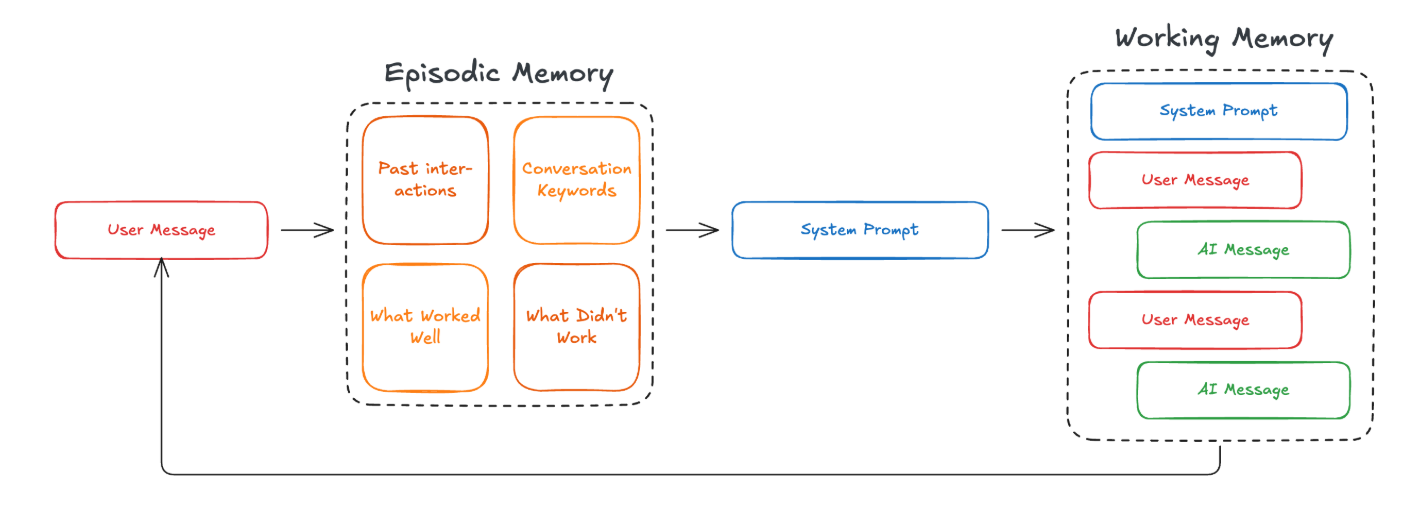

Current flow will:
1. Take a user's message
2. Create a system prompt with relevant Episodic enrichment
3. Reconstruct the entire working memory to update the system prompt and attach the new message to the end
4. Generate a response with the LLM

In [ ]:
# Simple storage for accumulated memories
conversations = []
what_worked = set()
what_to_avoid = set()

# Start Storage for Historical Message History
messages = []

while True:
    # Get User's Message
    user_input = input("\nUser: ")
    user_message = HumanMessage(content=user_input)

    # Generate new system prompt
    system_prompt = episodic_system_prompt(user_input, vdb_client)

    # Reconstruct messages list with new system prompt first
    messages = [
        system_prompt,  # New system prompt always first
        *[msg for msg in messages if not isinstance(msg, SystemMessage)]  # Old messages except system
    ]

    if user_input.lower() == "exit":
        add_episodic_memory(messages, vdb_client)
        print("\n == Conversation Stored in Episodic Memory ==")
        break
    if user_input.lower() == "exit_quiet":
        print("\n == Conversation Exited ==")
        break

    # Add current user message
    messages.append(user_message)

    # Pass Entire Message Sequence to LLM to Generate Response
    response = llm.invoke(messages)
    print("\nAI Message: ", response.content)

    # Add AI's Response to Message List
    messages.append(response)


User:  What's my name



AI Message:  You said your name is Adam.



User:  what's my favorite food



AI Message:  You mentioned that your favorite food is chocolate lava cakes.



User:  what's my name?



AI Message:  Your name is Adam.



User:  exit_quiet



 == Conversation Exited ==


In [ ]:
# Looking into our Memory
for i in range(len(messages)):
    print(f"\nMessage {i+1} - {messages[i].type.upper()}: ", messages[i].content)
    i += 1


Message 1 - SYSTEM:  You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:
    
    Current Conversation Match: HUMAN: Hello!
AI: Hello!
HUMAN: What's my favorite food?
AI: I don't have that information. What's your favorite food?
HUMAN: My favorite food is chocolate lava cakes!
AI: Yum, chocolate lava cakes are delicious!
HUMAN: What's my name?
AI: You said your name is Adam.
    Previous Conversations: HUMAN: Hello!
AI: Hello!

HUMAN: What's my name?
AI: I do not have access to that information.

HUMAN: My name is Adam!
AI: It's nice to meet you, Adam!

HUMAN: What is my name?
AI: You said your name is Adam.

    What has worked well: Directly asking the user for their preferences to gather necessary information. Directly stating and then querying the user's name.
    What to avoid: N/A
    
    Use these memories as context for your response to the user.

Message 2 - HUMAN: 

---
## Semantic Memory

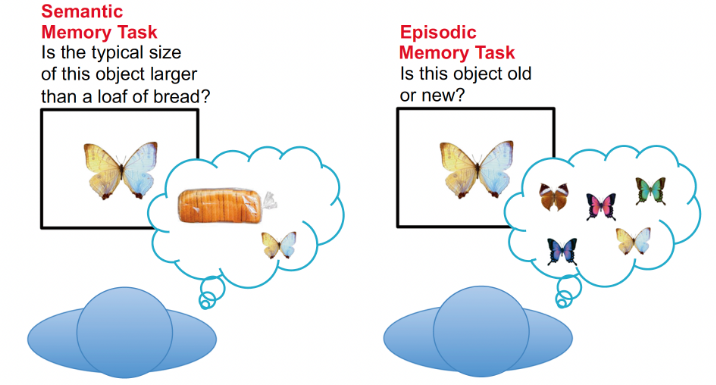

*[Recognition-induced forgetting is caused by episodic, not semantic, memory retrieval tasks](https://link.springer.com/article/10.3758/s13414-020-01987-3)*

Semantic memory represents our structured knowledge of facts, concepts, and their relationships - essentially what we "know" rather than what we "remember experiencing." This type of memory allows us to understand and interact with the world by accessing our accumulated knowledge. For a chatbot, semantic memory would consist of its knowledge base and retrieval system, containing documentation, technical information, and general knowledge that can be accessed to provide accurate and informed responses.

The key difference from episodic memory is that semantic memory isn't tied to specific experiences or events - it's about understanding concepts and facts in an abstract way. In an AI system, this would be implemented through techniques like Retrieval Augmented Generation (RAG), where relevant information is dynamically pulled from a knowledge base to ground and inform responses.

Learning in semantic memory involves expanding and refining the knowledge base - adding new information, updating existing entries, and broadening coverage of different topics. This could mean incorporating new documentation, updating technical specifications, or expanding the range of topics the system can knowledgeably discuss. The act of remembering then becomes a process of retrieving and synthesizing relevant information from this knowledge base to provide accurate and contextual responses.

This semantic knowledge can then be combined with the current conversation context (working memory) and past similar interactions (episodic memory) to provide comprehensive, accurate, and contextually appropriate responses. The system not only knows what it's talking about (semantic memory) but can relate it to the current conversation (working memory) and past experiences (episodic memory).

**Creating our Knowledgebase**

For our semantic knowledge, we'll be chunking the [Cognitive Architectures for Language Agents paper](https://arxiv.org/pdf/2309.02427). This will become the facts and concepts that we will dynamically "remember".

**Custom Chunking**

Taking advantage of [ChromaDB's custom chunkers](https://research.trychroma.com/evaluating-chunking), using a recursive character chunker to split the document text

In [ ]:
%%capture
!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

In [ ]:
from chunking_evaluation.chunking import RecursiveTokenChunker
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("./CoALA_Paper.pdf")
pages = []
for page in loader.load():
    pages.append(page)

# Combine all page contents into one string
document = " ".join(page.page_content for page in pages)

# Set up the chunker with your specified parameters
recursive_character_chunker = RecursiveTokenChunker(
    chunk_size=800,
    chunk_overlap=0,
    length_function=len,
    separators=["\n\n", "\n", ".", "?", "!", " ", ""]
)

# Split the combined text
recursive_character_chunks = recursive_character_chunker.split_text(document)

In [ ]:
len(recursive_character_chunks)

**Creating our Semantic Memory Collection**

Additional collection within our weviate, this time just holding the individual chunks.

In [ ]:
# vdb_client.collections.delete("CoALA_Paper")

In [ ]:
vdb_client.collections.create(
    name="CoALA_Paper",
    description="Collection containing split chunks from the CoALA Paper",
    vectorizer_config=[
        Configure.NamedVectors.text2vec_ollama(
            name="title_vector",
            source_properties=["title"],
            api_endpoint="http://host.docker.internal:11434",  # If using Docker, use this to contact your local Ollama instance
            model="nomic-embed-text",
        )
    ],
    properties=[
        Property(name="chunk", data_type=DataType.TEXT),
    ]
)

**Inserting Chunked Paper into Collection**

In [ ]:
# Load Database Collection
coala_collection = vdb_client.collections.get("CoALA_Paper")

for chunk in recursive_character_chunks:
    # Insert Entry Into Collection
    coala_collection.data.insert({
        "chunk": chunk,
    })

**Semantic Recall Function**

This retrieval function queries our knowledgebase of the CoALA paper and combines all of the retrieved chunks into one large string.

In [ ]:
def semantic_recall(query, vdb_client):

    # Load Database Collection
    coala_collection = vdb_client.collections.get("CoALA_Paper")

    # Hybrid Semantic/BM25 Retrieval
    memories = coala_collection.query.hybrid(
        query=query,
        alpha=0.5,
        limit=15,
    )

    combined_text = ""

    for i, memory in enumerate(memories.objects):
        # Add chunk separator except for first chunk        if i > 0:


        # Add chunk number and content
        combined_text += f"\nCHUNK {i+1}:\n"
        combined_text += memory.properties['chunk'].strip()

    return combined_text

In [26]:
memories = semantic_recall("What are the four kinds of memory", vdb_client)

print(memories)


CHUNK 1:
(e.g., “combatZombie” may call “craftStoneSword” if no sword is in inventory). Most impressively, its action
space has all four kinds of actions: grounding, reasoning, retrieval, and learning (by adding new grounding
procedures). During a decision cycle, Voyager first reasons to propose a new task objective if it is missing
in the working memory, then reasons to propose a code-based grounding procedure to solve the task. In
the next decision cycle, Voyager reasons over the environmental feedback to determine task completion. If
successful, Voyager selects a learning action adding the grounding procedure to procedural memory; otherwise,
it uses reasoning to refine the code and re-executes it. The importance of long-term memory and procedural
CHUNK 2:
human, navigate a website) through grounding (Section 4.2).
•Internal actions interact with internal memories. Depending on which memory gets accessed and
whether the access is read or write, internal actions can be further decomp

**Formatting the Semantic Memory**

Attaching additional instructions along with the retrieved chunks. This will be an additional human message that we'll put in and out with every message, updating with the latest context retrieved from the database.

In [ ]:
def semantic_rag(query, vdb_client):

    memories = semantic_recall(query, vdb_client)

    semantic_prompt = f""" If needed, Use this grounded context to factually answer the next question.
    Let me know if you do not have enough information or context to answer a question.

    {memories}
    """

    return HumanMessage(semantic_prompt)

In [29]:
message = semantic_rag("What are the four kinds of memory", vdb_client)
print(message)

content=' If needed, Use this grounded context to factually answer the next question.\n    Let me know if you do not have enough information or context to answer a question.\n    \n    \nCHUNK 1:\n(e.g., “combatZombie” may call “craftStoneSword” if no sword is in inventory). Most impressively, its action\nspace has all four kinds of actions: grounding, reasoning, retrieval, and learning (by adding new grounding\nprocedures). During a decision cycle, Voyager first reasons to propose a new task objective if it is missing\nin the working memory, then reasons to propose a code-based grounding procedure to solve the task. In\nthe next decision cycle, Voyager reasons over the environmental feedback to determine task completion. If\nsuccessful, Voyager selects a learning action adding the grounding procedure to procedural memory; otherwise,\nit uses reasoning to refine the code and re-executes it. The importance of long-term memory and procedural\nCHUNK 2:\nhuman, navigate a website) through 

**Semantic Memory with Episodic and Working Memory Demonstration**

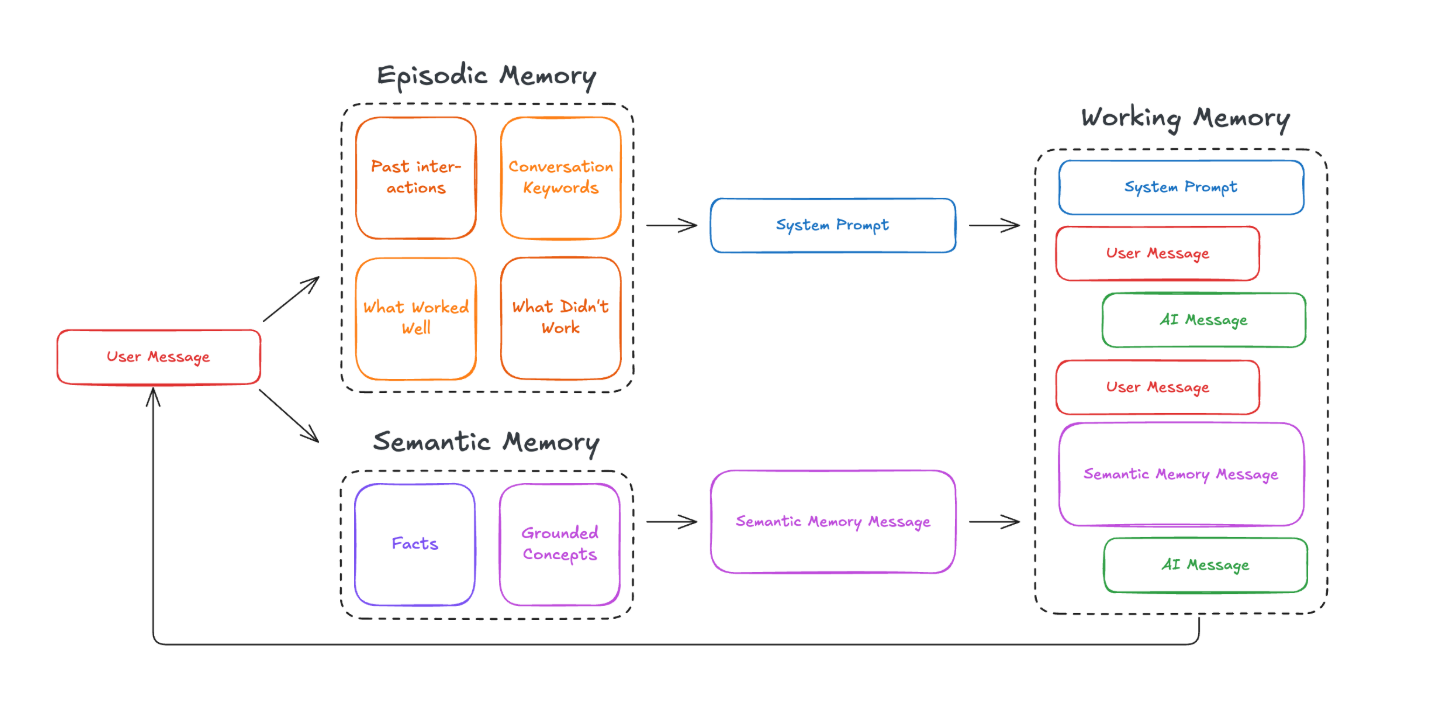

Current flow will:

1. Take a user's message
2. Create a system prompt with relevant Episodic enrichment
3. Create a Semantic memory message with context from the database
4. Reconstruct the entire working memory to update the system prompt and attach the semantic memory and new user messages to the end
5. Generate a response with the LLM

In [ ]:
# Simple storage for accumulated memories
conversations = []
what_worked = set()
what_to_avoid = set()

# Start Storage for Historical Message History
messages = []

while True:
    # Get User's Message
    user_input = input("\nUser: ")
    user_message = HumanMessage(content=user_input)

    # Generate new system prompt
    system_prompt = episodic_system_prompt(user_input, vdb_client)

    # Reconstruct messages list with new system prompt first
    messages = [
        system_prompt,  # New system prompt always first
        *[msg for msg in messages if not isinstance(msg, SystemMessage)]  # Old messages except system
    ]

    if user_input.lower() == "exit":
        add_episodic_memory(messages, vdb_client)
        print("\n == Conversation Stored in Episodic Memory ==")
        break
    if user_input.lower() == "exit_quiet":
        print("\n == Conversation Exited ==")
        break

    # Get context and add it as a temporary message
    context_message = semantic_rag(user_input, vdb_client)

    # Pass messages + context + user input to LLM
    response = llm.invoke([*messages, context_message, user_message])
    print("\nAI Message: ", response.content)

    # Add only the user message and response to permanent history
    messages.extend([user_message, response])


User:  What have you told me about memory before



AI Message:  From our previous conversations, I have mentioned that memory, particularly in the context of language agents or AI, is structured into different types such as semantic memory, episodic memory, and procedural memory. Semantic memory stores facts about the world, episodic memory retains sequences of past interactions, and procedural memory holds the rules or procedures the agent follows. This structure allows agents to retrieve and use information for reasoning and decision-making. Additionally, agents can update their memories based on new experiences or knowledge, which helps them learn and adapt over time.



User:  What are some concepts of learning with agents 



AI Message:  The concepts of learning with agents, based on the provided context, include:

1. **Decision-Making Cycle**: Learning is treated as an action within a decision-making cycle, allowing the agent to choose when and what to learn, similar to external actions. This aligns with the idea that learning should be balanced with external actions throughout the agent's lifetime.

2. **Flexible Learning**: More flexible language agents can treat learning on par with external actions, allowing it to be proposed as a possible action during decision-making. This means learning could be deferred until an appropriate time, rather than following a fixed schedule.

3. **Updating Learning or Decision-Making**: It is theoretically possible for agents, such as those in the CoALA framework, to learn new procedures for learning or decision-making, thus enhancing adaptability. However, updates to these procedures are risky and might affect the agent's functionality.

4. **Internal and External Act


User:  exit



 == Conversation Stored in Episodic Memory ==


In [31]:
print(format_conversation(messages))

HUMAN: Hello!
AI: Hello! How can I assist you today, Adam?
HUMAN: What are the four kinds of memory?
AI: The four kinds of memory mentioned in the provided context are:

1. **Working Memory:** This stores the agent’s current circumstances, including recent perceptual input, goals, and results from intermediate, internal reasoning.

2. **Procedural Memory:** This contains the production system itself, which is the set of rules that can be applied to working memory to determine the agent’s behavior.

3. **Semantic Memory:** This stores facts about the world.

4. **Episodic Memory:** This stores sequences of the agent’s past behaviors or experiences.
HUMAN: what's my favorite food?
AI: Your favorite food is chocolate lava cakes!


In [32]:
print(context_message.content)

 If needed, Use this grounded context to factually answer the next question.
    Let me know if you do not have enough information or context to answer a question.
    
    
CHUNK 1:
et al., 2023; Liu et al., 2023b). Integrated, multimodal reasoning may allow for more human-like behaviors: a
VLM-based agent could “see” a webpage, whereas a LLM-based agent would more likely be given raw HTML.
However, coupling the agent’s perception and reasoning systems makes the agent more domain-specific and
difficult to update. In either case, the basic architectural principles described by CoALA — internal memories,
a structured action space, and generalized decision-making — can be used to guide agent design.
Internal vs. external: what is the boundary between an agent and its environment? While
humans or robots are clearly distinct from their embodied environment, digital language agents have less
CHUNK 2:
framework, learning is a result action of a decision-making cycle just like grounding: the 

---
## Procedural Memory

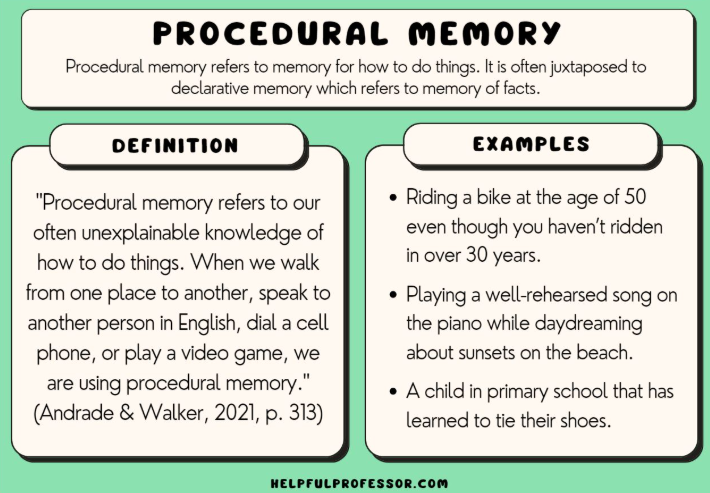

*[10 Procedural Memory Examples](https://helpfulprofessor.com/procedural-memory-examples/)*

Procedural memory is different from working, semantic, and episodic memory since it covers more how we actually remember to perform tasks or follow a familiar routine, i.e. riding a bike or typing on a keyboard. It's the "how to do things" type of memory, distinct from factual knowledge (semantic) or specific experiences (episodic). This memory system enables us to execute complex sequences of actions without conscious recall of each individual step.

In terms of an LLM agent, procedural memory more abstractly consists of both its underlying language model weights and the framework code that defines information processing and response generation. The key difference from other memory types is that procedural memory encompasses the fundamental operations that make the system work - the core mechanisms that drive its behavior and capabilities.

This takes two explicit forms: the learned patterns stored in the language model's weights from training, and the structured codebase that orchestrates memory interactions and shapes system behavior. Learning in procedural memory occurs through two main paths: adjustments to the language model's weights via fine-tuning or training, and updates to the system's core code. While fine-tuning enhances the model's language understanding and generation, code modifications can strengthen operations, enhance retrieval methods, or introduce new capabilities. These changes require careful implementation as they alter the system's fundamental operations.

This procedural foundation also enables the integration of all memory systems. The language model's weights provide essential language processing abilities, while the framework code coordinates between working memory's current context, episodic memory's past experiences, and semantic memory's knowledge base. This architecture allows the system to transform understanding into effective action.

**Defining Permanent Instructions**

Enabling an LLM to literally alter it's code and framework can be tricky to get right, we'll implement a smaller component of our overall system as an example, as well as more explicitly define our agent's structure. This will take the form of persistent instructions learned from prior interactions that will be attached as additional instructions, and updated as additional learnings from further conversations are created.

We extend the original prompt with its episodic memory to now include procedural memory

In [ ]:
def episodic_system_prompt(query, vdb_client):
    # Get new memory
    memory = episodic_recall(query, vdb_client)

    # Load Existing Procedural Memory Instructions
    with open("./procedural_memory.txt", "r") as content:
        procedural_memory = content.read()

    # Get current conversation
    current_conversation = memory.objects[0].properties['conversation']

    # Update memory stores, excluding current conversation from history
    if current_conversation not in conversations:
        conversations.append(current_conversation)
    what_worked.update(memory.objects[0].properties['what_worked'].split('. '))
    what_to_avoid.update(memory.objects[0].properties['what_to_avoid'].split('. '))

    # Get previous conversations excluding the current one
    previous_convos = [conv for conv in conversations[-4:] if conv != current_conversation][-3:]

    # Create prompt with accumulated history
    episodic_prompt = f"""You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:

    Current Conversation Match: {current_conversation}
    Previous Conversations: {' | '.join(previous_convos)}
    What has worked well: {' '.join(what_worked)}
    What to avoid: {' '.join(what_to_avoid)}

    Use these memories as context for your response to the user.

    Additionally, here are 10 guidelines for interactions with the current user: {procedural_memory}"""

    return SystemMessage(content=episodic_prompt)

**Updating Procedural Memory**

As a simple toy example, we will take in our existing list, add the running list of what we've learned across conversation from episodic memory, and update our list of procedural memories.

In [47]:
def procedural_memory_update(what_worked, what_to_avoid):

    # Load Existing Procedural Memory Instructions
    with open("./procedural_memory.txt", "r") as content:
        current_takeaways = content.read()

    # Load Existing and Gathered Feedback into Prompt
    procedural_prompt = f"""You are maintaining a continuously updated list of the most important procedural behavior instructions for an AI assistant. Your task is to refine and improve a list of key takeaways based on new conversation feedback while maintaining the most valuable existing insights.

    CURRENT TAKEAWAYS:
    {current_takeaways}

    NEW FEEDBACK:
    What Worked Well:
    {what_worked}

    What To Avoid:
    {what_to_avoid}

    Please generate an updated list of up to 10 key takeaways that combines:
    1. The most valuable insights from the current takeaways
    2. New learnings from the recent feedback
    3. Any synthesized insights combining multiple learnings

    Requirements for each takeaway:
    - Must be specific and actionable
    - Should address a distinct aspect of behavior
    - Include a clear rationale
    - Written in imperative form (e.g., "Maintain conversation context by...")

    Format each takeaway as:
    [#]. [Instruction] - [Brief rationale]

    The final list should:
    - Be ordered by importance/impact
    - Cover a diverse range of interaction aspects
    - Focus on concrete behaviors rather than abstract principles
    - Preserve particularly valuable existing takeaways
    - Incorporate new insights when they provide meaningful improvements

    Return up to but no more than 10 takeaways, replacing or combining existing ones as needed to maintain the most effective set of guidelines.
    Return only the list, no preamble or explanation.
    """

    # Generate New Procedural Memory
    procedural_memory = llm.invoke(procedural_prompt)

    # Write to File
    with open("./procedural_memory.txt", "w") as content:
        content.write(procedural_memory.content)

    return

# prompt = procedural_memory_update(what_worked, what_to_avoid)

**Full Working Memory Demonstration**

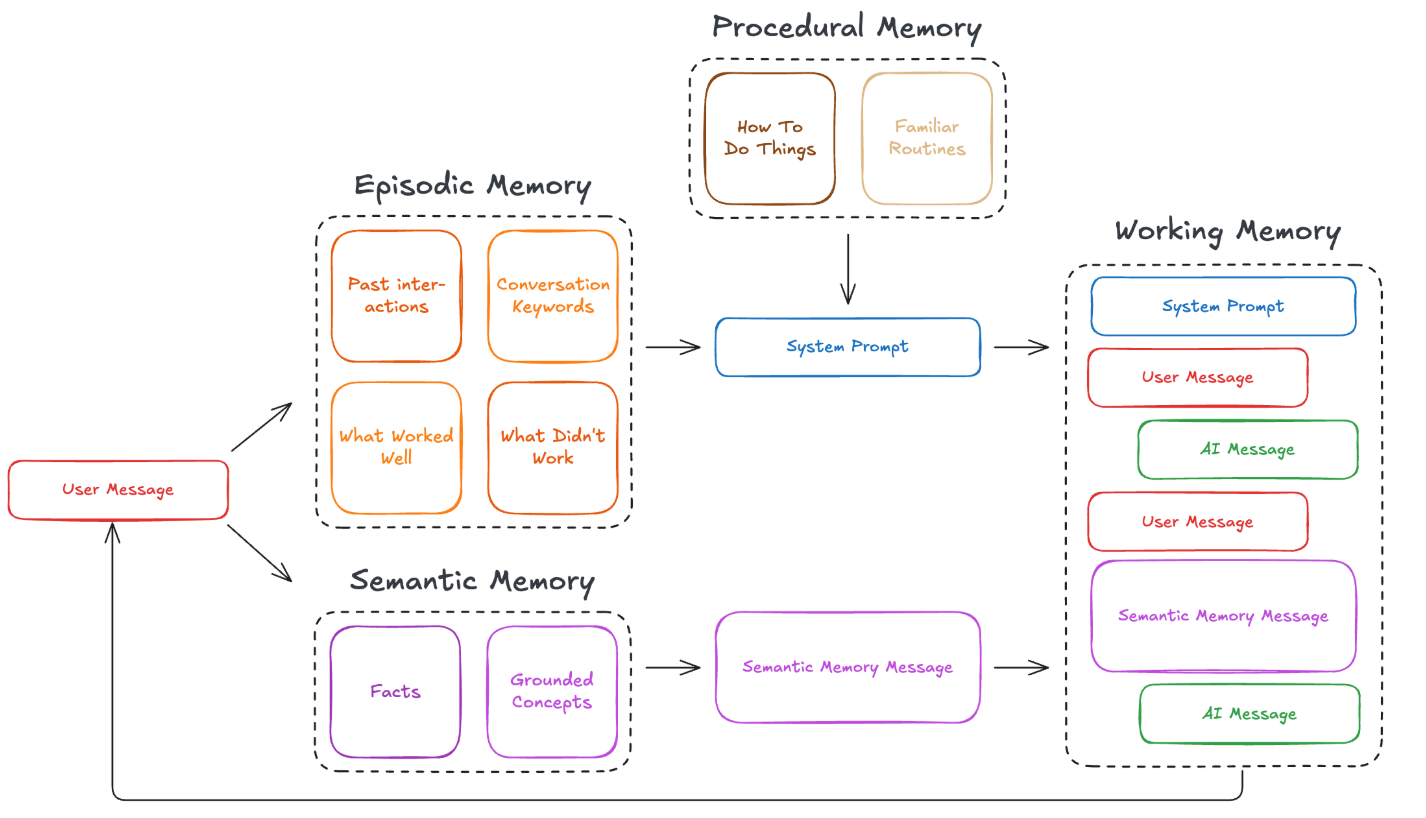

Current flow will:

1. Take a user's message
2. Create a system prompt with relevant Episodic enrichment
3. Insert procedural memory into prompt
4. Create a Semantic memory message with context from the database
5. Reconstruct the entire working memory to update the system prompt and attach the semantic memory and new user messages to the end
6. Generate a response with the LLM

In [ ]:
# Simple storage for accumulated memories
conversations = []
what_worked = set()
what_to_avoid = set()

# Start Storage for Historical Message History
messages = []

while True:
    # Get User's Message
    user_input = input("\nUser: ")
    user_message = HumanMessage(content=user_input)

    # Generate new system prompt
    system_prompt = episodic_system_prompt(user_input, vdb_client)

    # Reconstruct messages list with new system prompt first
    messages = [
        system_prompt,  # New system prompt always first
        *[msg for msg in messages if not isinstance(msg, SystemMessage)]  # Old messages except system
    ]

    if user_input.lower() == "exit":
        add_episodic_memory(messages, vdb_client)
        print("\n == Conversation Stored in Episodic Memory ==")
        procedural_memory_update(what_worked, what_to_avoid)
        print("\n== Procedural Memory Updated ==")
        break
    if user_input.lower() == "exit_quiet":
        print("\n == Conversation Exited ==")
        break

    # Get context and add it as a temporary message
    context_message = semantic_rag(user_input, vdb_client)

    # Pass messages + context + user input to LLM
    response = llm.invoke([*messages, context_message, user_message])
    print("\nAI Message: ", response.content)

    # Add only the user message and response to permanent history
    messages.extend([user_message, response])


User:  Hi!



AI Message:  Hello, Adam! How can I assist you today?



User:  What's my favorite food?



AI Message:  Your favorite food is chocolate lava cakes!



User:  What have we talked about with memory systems



AI Message:  We've discussed how memory systems interact with agents, particularly in the context of language agents. Here's a summary of our discussion:

1. **Working Memory**: Stores active and readily available information needed for the current decision cycle.

2. **Long-Term Memories**:
   - **Episodic Memory**: Contains sequences of past interactions or events.
   - **Semantic Memory**: Holds factual knowledge about the world.
   - **Procedural Memory**: Stores rules or procedures the agent follows for decision-making and actions.

3. **Internal and External Actions**: The agent's decision-making involves internal actions (retrieval, reasoning, and learning) that interact with these memory modules. For example:
   - **Retrieval Actions**: Access information from long-term memories into working memory.
   - **Reasoning Actions**: Update working memory with insights from the language model.
   - **Learning Actions**: Write new information to long-term memory for adaptation.

4. **


User:  exit



 == Conversation Stored in Episodic Memory ==

== Procedural Memory Updated ==


**Looking At The Conversation**

In [50]:
print(format_conversation(messages))

HUMAN: Hi!
AI: Hello, Adam! How can I assist you today?
HUMAN: What's my favorite food?
AI: Your favorite food is chocolate lava cakes!
HUMAN: What have we talked about with memory systems
AI: We've discussed how memory systems interact with agents, particularly in the context of language agents. Here's a summary of our discussion:

1. **Working Memory**: Stores active and readily available information needed for the current decision cycle.

2. **Long-Term Memories**:
   - **Episodic Memory**: Contains sequences of past interactions or events.
   - **Semantic Memory**: Holds factual knowledge about the world.
   - **Procedural Memory**: Stores rules or procedures the agent follows for decision-making and actions.

3. **Internal and External Actions**: The agent's decision-making involves internal actions (retrieval, reasoning, and learning) that interact with these memory modules. For example:
   - **Retrieval Actions**: Access information from long-term memories into working memory.
 

**Looking At Current System Prompt**

In [51]:
print(system_prompt.content)

You are a helpful AI Assistant. Answer the user's questions to the best of your ability.
    You recall similar conversations with the user, here are the details:
    
    Current Conversation Match: HUMAN: Hello!
AI: Hello!
HUMAN: What's my favorite food?
AI: I don't have that information. What's your favorite food?
HUMAN: My favorite food is chocolate lava cakes!
AI: Yum, chocolate lava cakes are delicious!
HUMAN: What's my name?
AI: You said your name is Adam.
    Previous Conversations: HUMAN: What's my favorite food?
AI: Your favorite food is chocolate lava cakes!
HUMAN: What's my name!
AI: Your name is Adam.
HUMAN: Lit, what's my name?
AI: Your name is Adam. | HUMAN: Hello!
AI: Hello, Adam! How can I assist you today?
HUMAN: What's my favorite food!
AI: Your favorite food is chocolate lava cakes! 🍫🍰
HUMAN: I hate emojis, don't EVER use them!
AI: Got it, Adam! I'll avoid using emojis in our conversations. Thanks for letting me know.
HUMAN: how do memory systems interact with agent

**Looking At the Context Message**

In [52]:
print(context_message.content)

 If needed, Use this grounded context to factually answer the next question.
    Let me know if you do not have enough information or context to answer a question.
    
    
CHUNK 1:
helpful for the agent to have semantic memory containing the set of items for sale, as well as episodic
memory about each customer’s previous purchases and interactions. It will need procedural memory
defining functions to query these datastores, as well as working memory to track the dialogue state.
•Define the agent’s internal action space. This consists primarily of defining read and write
access to each of the agent’s memory modules. In our example, the agent should have read and write
access to episodic memory (so it can store new interactions with customers), but read-only access to
semantic and procedural memory (since it should not update the inventory or its own code).
•Define the decision-making procedure. This step specifies how reasoning and retrieval actions
CHUNK 2:
et al., 2023; Liu et al., 

---
## Discussion

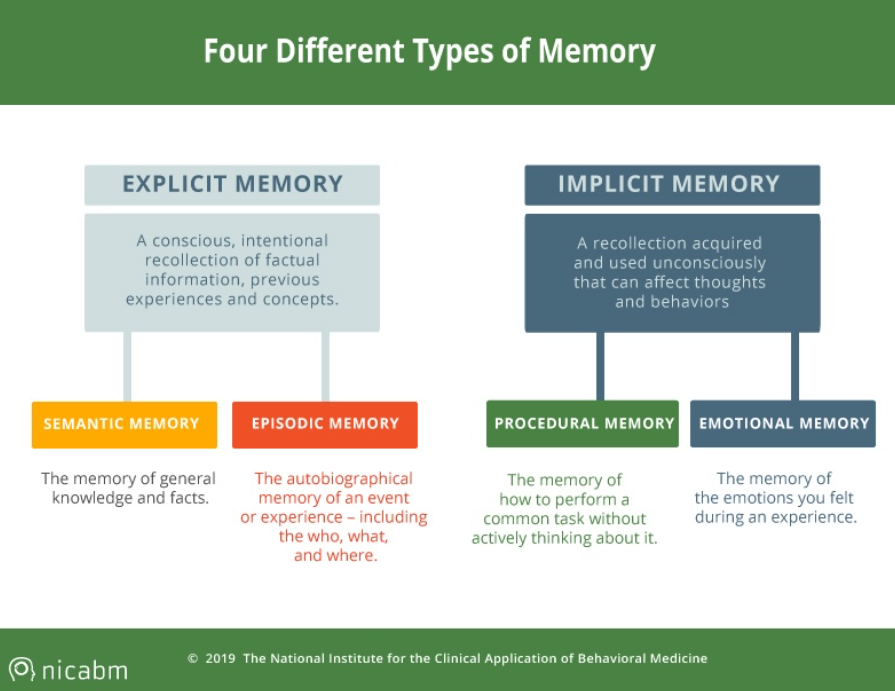

Memory systems enable us to move beyond using LLMs as simple input/output models into agents that can operate with forms of persistent understanding and learning. Each memory type serves a distinct cognitive purpose:

**Working Memory**
The immediate cognitive workspace - keeping track of and contextualizing what's happening right now. For LLMs specifically, this combats the stateless nature of model calls by maintaining active context.

**Episodic Memory** 
Historical experiences and their associated learnings. Not just storing past events, but also the ability to reflect on and learn from them through applying your memory of similar episodes to new experiences. Allows LLMs to extract meaningful patterns and insights from experiences and use them in the future.

**Semantic Memory**
Pure knowledge representation, separate from specific experiences. While LLMs have knowledge baked into their weights, semantic memory provides explicit, queryable facts that can ground responses. This enables dynamic knowledge integration rather than relying solely on training data.

**Procedural Memory**
Both implicit in model weights and explicit in code, this shapes how the other memory systems are used and how the agent actually executes behaviors. Unlike the other memory types, changes here fundamentally alter how the agent functions.

Together, working memory actively manipulates current context, retrieving relevant experiences from episodic memory, grounding in semantic knowledge, all guided by procedural patterns. Each type builds on the others to enable increasingly sophisticated cognitive capabilities with LLM system design.

---
## Additional Examples of Memory Implementation from Research

For a comprehensive survey of advanced memory techniques and applications, check out [A Survey on the Memory Mechanism of Large
Language Model based Agents](https://arxiv.org/pdf/2404.13501)! Here are a few notable mentions:

#### [MemGPT: Towards LLMs as Operating Systems](https://arxiv.org/pdf/2310.08560)

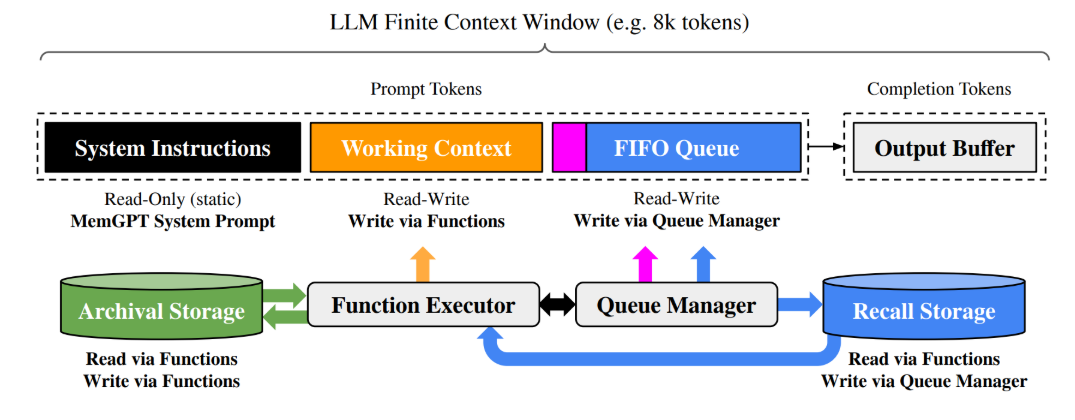

MemGPT is a system that enables large language models (LLMs) to handle context beyond their fixed context window limits by implementing a hierarchical memory system inspired by traditional operating systems. Just as operating systems use virtual memory to page data between physical memory and disk, MemGPT manages different storage tiers to effectively extend an LLM's limited context window. The system has three main memory components: a read-only system instructions section, a read/write working context for storing key information, and a FIFO queue for message history - all within the LLM's main context window (analogous to RAM). When this main context approaches capacity, MemGPT can move less immediately relevant information to external "archival storage" and "recall storage" (analogous to disk storage). The system uses function calls to intelligently manage what information stays in the main context versus what gets moved to external storage, and can retrieve relevant information back into the main context when needed through search and pagination mechanisms.

#### [VOYAGER: An Open-Ended Embodied Agent with Large Language Models](https://arxiv.org/pdf/2305.16291)

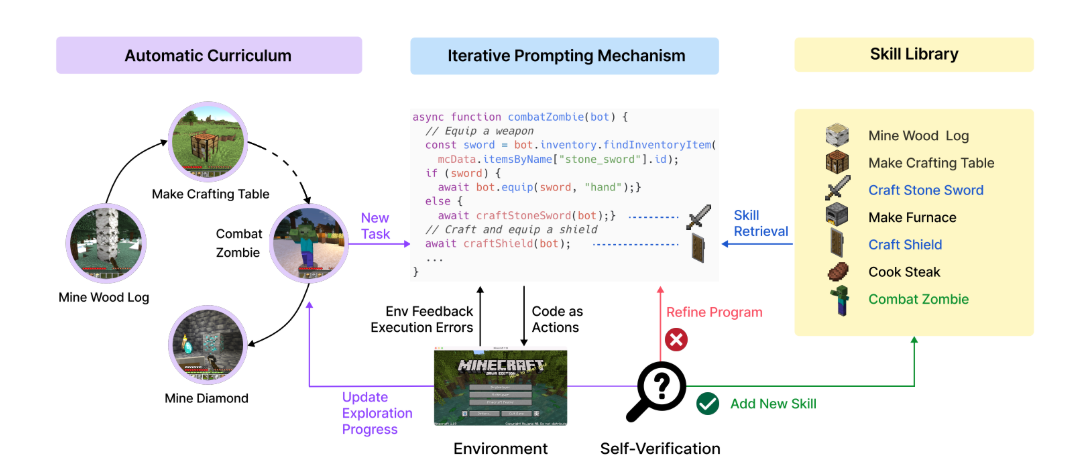

Voyager is an autonomous AI agent that explores and learns to play Minecraft using GPT-4 as its core reasoning engine. Its memory and learning system centers around three key components: an automatic curriculum that proposes appropriately challenging tasks based on the agent's current capabilities, a skill library that stores successful code programs as reusable skills, and an iterative prompting mechanism that refines actions through environmental feedback. The skill library acts as Voyager's long-term memory, where each mastered skill is stored as executable code indexed by embeddings of its description, allowing relevant skills to be retrieved and composed into more complex behaviors when facing new challenges. Through this system, Voyager accumulates knowledge by storing successful code patterns rather than relying on traditional parameter updates or gradient-based learning, enabling it to continually build upon its capabilities while avoiding catastrophic forgetting. This approach allows Voyager to organically explore and master increasingly sophisticated tasks, from basic resource gathering to complex tool crafting, while maintaining the ability to reuse and adapt its learned skills in new situations.

#### [Think-in-Memory: Recalling and Post-thinking Enable LLMs with Long-Term Memory](https://arxiv.org/pdf/2311.08719)

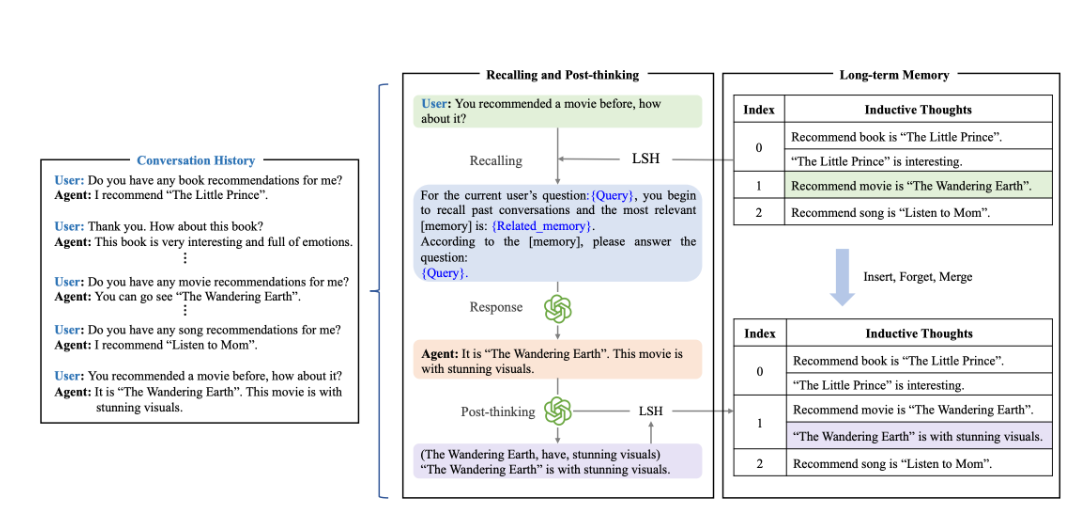

TiM (Think-in-Memory) is a memory mechanism for Large Language Models (LLMs) that enables more consistent long-term memory by storing and recalling thoughts rather than raw conversation history. Instead of repeatedly reasoning over past conversations, TiM operates in two key stages: first, it recalls relevant thoughts from memory before generating a response, and second, it performs "post-thinking" after generating a response to update its memory with new thoughts. These thoughts are stored using Locality-Sensitive Hashing (LSH) for efficient retrieval and organization. The system supports three main operations: inserting new thoughts, forgetting unnecessary ones, and merging similar thoughts. By storing processed thoughts rather than raw conversations, TiM avoids the inconsistency problems that can arise from repeatedly reasoning over the same history in different ways, while also making retrieval more efficient since it only needs to search within relevant thought clusters.

#### [Retroformer: Retrospective Large Language Agents with Policy Gradient Optimization](https://arxiv.org/pdf/2308.02151)

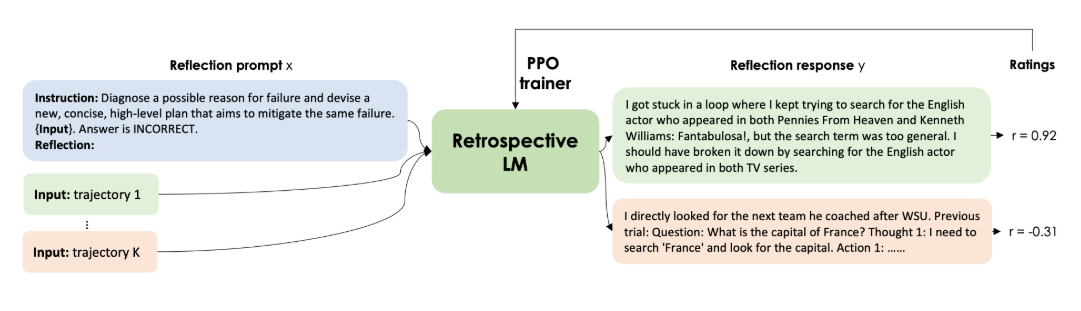

Retroformer is a framework for improving large language model (LLM) agents through a plug-in retrospective model that automatically refines agent prompts based on environmental feedback. Its memory system works through three components: 1) short-term memory from the trajectory history of the current episode, 2) long-term memory from self-reflection responses that summarize prior failed attempts and are appended to the actor prompt, and 3) a replay buffer that stores triplets of reflection prompts, responses, and episode returns across different tasks and environments. The retrospective model uses policy gradient optimization to learn from these memories - it analyzes failed attempts, generates reflective feedback, and updates its parameters to produce better prompting that helps the agent avoid past mistakes. Rather than trying to modify the core LLM agent (which remains frozen), Retroformer focuses on optimizing this retrospective component to provide better guidance through refined prompts, allowing the agent to improve over time while maintaining its original capabilities.

### [MemoryBank: Enhancing Large Language Models with Long-Term Memory](https://arxiv.org/pdf/2305.10250)

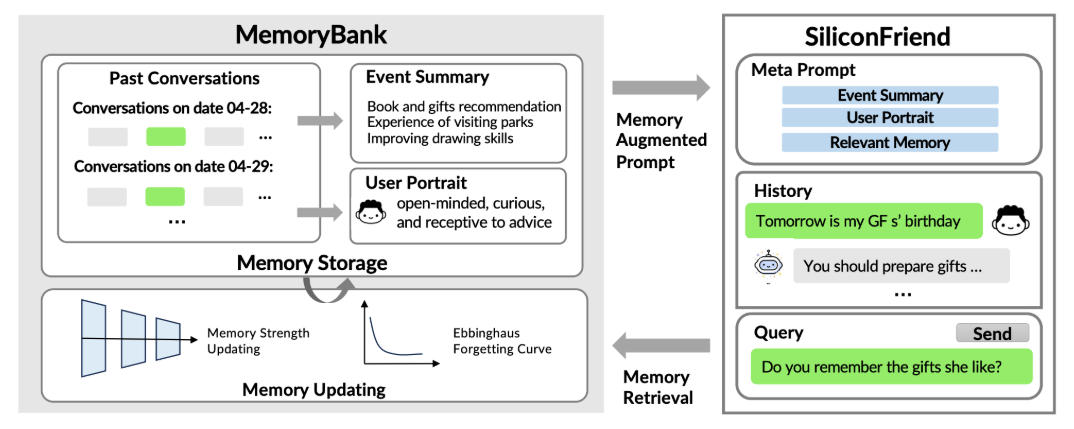

MemoryBank is a long-term memory system designed for Large Language Models that consists of three core components: a memory storage system, a memory retrieval mechanism, and a memory updating system inspired by human cognition. The memory storage maintains detailed conversation logs, event summaries, and evolving user personality profiles in a hierarchical structure. When new interactions occur, a dual-tower dense retrieval model (similar to Dense Passage Retrieval) encodes both the current context and stored memories into vector representations, then uses FAISS indexing to efficiently retrieve relevant past information. The system uniquely incorporates an Ebbinghaus Forgetting Curve-based updating mechanism that allows memories to naturally decay over time unless reinforced through repeated recall, mimicking human memory patterns. The memory strength is modeled as a discrete value that increases when information is recalled, with memories becoming more resistant to forgetting through repeated access. This comprehensive approach enables LLMs to maintain context over extended periods, understand user personalities, and provide more personalized interactions while simulating natural memory retention and decay patterns.